## Mathematical Framework

### 1. Stock Price Process and Individual Returns

Let $ P_t^{(i)} $ denote the price of stock $ i $ at time $ t $.
The daily return for stock $ i $ is computed as

$
R_t^{(i)} = \frac{P_t^{(i)} - P_{t-1}^{(i)}}{P_{t-1}^{(i)}}
$

Similarly, let $ P_t^{m} $ denote the OBX market index level at time $ t $, with market daily return:

$
R_t^{m} = \frac{P_t^{m} - P_{t-1}^{m}}{P_{t-1}^{m}}
$

---

### 2. Risk-Free Rate

Let $ y_t $ denote the annualized Norwegian 10-year government bond yield (in percent).
It is converted to a daily risk-free rate as

$
R_t^{f} = \frac{y_t}{100 \cdot 252}
$

---

### 3. Moving Averages of Individual Stock Prices

For a window length $ n \in \{50, 100, 200\} $, the simple moving average (SMA) of stock $ i $ is defined as

$
\text{SMA}_{t}^{(i,n)} = \frac{1}{n} \sum_{j=0}^{n-1} P_{t-j}^{(i)}
$

---

### 4. Trading Signal (Golden Cross / Death Cross) for Individual Stocks

The trading signal for stock $ i $ is based on the relative position of its short-term and long-term moving averages:

$
S_t^{(i)} =
\begin{cases}
1, & \text{if } \text{SMA}_{t}^{(i,50)} > \text{SMA}_{t}^{(i,200)} \\
0, & \text{otherwise}
\end{cases}
$

To avoid look-ahead bias, the position is lagged by one period:

$
\pi_t^{(i)} = S_{t-1}^{(i)}
$

where $ \pi_t^{(i)} \in \{0,1\} $ denotes the portfolio exposure for stock $ i $.

---

### 5. Strategy Returns on Individual Stocks

The strategy return for stock $ i $ at time $ t $ is the stock's return multiplied by the position:

$
R_t^{\text{strat},(i)} = \pi_t^{(i)} \cdot R_t^{(i)}
$

---

### 6. Cumulative Returns

Cumulative returns for each stock's strategy and the market are computed multiplicatively:

$
\text{CR}_T^{\text{strat},(i)} = \prod_{t=1}^{T} (1 + R_t^{\text{strat},(i)}) - 1
$

$
\text{CR}_T^{m} = \prod_{t=1}^{T} (1 + R_t^{m}) - 1
$

---

### 7. Excess Returns

Excess returns over the risk-free rate are defined as:

For stock $ i $ strategy:
$
\tilde{R}_t^{\text{strat},(i)} = R_t^{\text{strat},(i)} - R_t^{f}
$

For the market:
$
\tilde{R}_t^{m} = R_t^{m} - R_t^{f}
$

---

### 8. Pooled CAPM Regression Model

For each moving average combination (50-200, 50-100, 100-200), we pool the excess returns from all stocks and estimate a single CAPM model via ordinary least squares (OLS):

$
\tilde{R}_t^{\text{strat},(i)} = \alpha + \beta \tilde{R}_t^{m} + \varepsilon_t^{(i)}
$

where:
- $ \alpha $ measures abnormal performance (average strategy alpha across all stocks),
- $ \beta $ measures average market exposure of the strategy,
- $ \varepsilon_t^{(i)} $ is an error term.

This regression is estimated on the pooled data:

$
\mathbf{y} = \begin{pmatrix}
\tilde{R}_1^{\text{strat},(1)} \\
\vdots \\
\tilde{R}_T^{\text{strat},(1)} \\
\tilde{R}_1^{\text{strat},(2)} \\
\vdots \\
\tilde{R}_T^{\text{strat},(n)} 
\end{pmatrix},
\quad
\mathbf{X} = \begin{pmatrix}
1 & \tilde{R}_1^{m} \\
\vdots & \vdots \\
1 & \tilde{R}_T^{m} \\
1 & \tilde{R}_1^{m} \\
\vdots & \vdots \\
1 & \tilde{R}_T^{m} 
\end{pmatrix}
$

The OLS estimator is:

$
\hat{\theta} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$

---

### 9. Estimation and Inference

Statistical significance of $ \alpha $ is assessed using a $ t $-test:

$
t_\alpha = \frac{\hat{\alpha}}{\text{SE}(\hat{\alpha})}
$

The associated $ p $-value tests the null hypothesis:

$
H_0 : \alpha = 0
$

---

### 10. Interpretation

- A statistically significant $ \alpha > 0 $ indicates risk-adjusted outperformance on average across all stocks.
- $ \beta \approx 1 $ implies the strategy maintains market-like exposure.
- $ \beta < 1 $ indicates defensive behavior, with reduced market exposure due to time spent out of the market when the signal is inactive.
- Testing $ \alpha = 0 $ evaluates whether the moving average strategy provides risk-adjusted returns beyond what EMH would predict.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
NY = pd.read_csv('Norway 10-Year Bond Yield Historical Data.csv', index_col=0, parse_dates=True)
NY1 = pd.read_csv('Norway 10-Year Bond Yield Historical Data (1).csv', index_col=0, parse_dates=True)

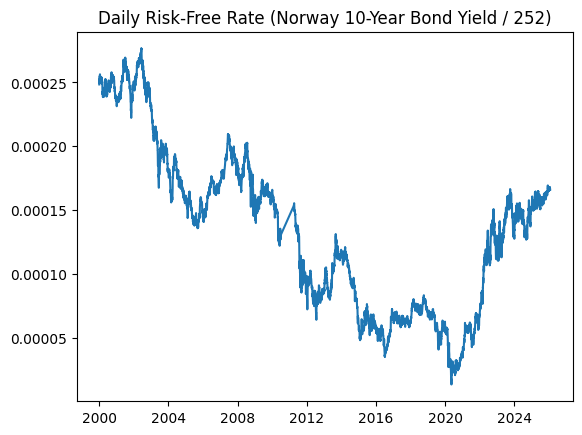

In [4]:
# merge NY and NY1 on their datetime index into one dataframe
NY.index = pd.to_datetime(NY.index)
NY1.index = pd.to_datetime(NY1.index)
df = pd.concat([NY, NY1]).sort_index().groupby(level=0).first()
rf = df['Price'] / 100 / 252  # Convert annualized yield to daily risk-free rate
plt.plot(rf)
plt.title('Daily Risk-Free Rate (Norway 10-Year Bond Yield / 252)')
plt.show()

In [5]:
def strategy_returns(price_arr, dates=None, initial_capital=1_000_000, tc=0.0):
    """
    price_arr: numpy array or list of prices
    dates: optional array-like of datetimes (same length)
    returns: DataFrame with columns: ret_mkt, ret_50_200, ret_50_100, ret_100_200, and portfolio values
    """
    s = pd.Series(np.asarray(price_arr, dtype=float))
    if dates is not None:
        s.index = pd.to_datetime(dates)
    ret = s.pct_change()
    ma50 = s.rolling(50).mean()
    ma100 = s.rolling(100).mean()
    ma200 = s.rolling(200).mean()
    def _strat(short, long):
        signal = (short > long).astype(int)
        pos = signal.shift(1).fillna(0)
        trade = pos.diff().abs().fillna(0)
        tc_cost = trade * tc
        strat_ret = pos * ret - tc_cost
        return strat_ret
    r_50_200 = _strat(ma50, ma200).rename('ret_50_200')
    r_50_100 = _strat(ma50, ma100).rename('ret_50_100')
    r_100_200 = _strat(ma100, ma200).rename('ret_100_200')
    out = pd.concat([ret.rename('ret_mkt'), r_50_200, r_50_100, r_100_200], axis=1)
    out['portfolio_50_200'] = initial_capital * (1 + out['ret_50_200'].fillna(0)).cumprod()
    out['portfolio_50_100'] = initial_capital * (1 + out['ret_50_100'].fillna(0)).cumprod()
    out['portfolio_100_200'] = initial_capital * (1 + out['ret_100_200'].fillna(0)).cumprod()
    return out

# Pool returns from multiple tickers and run CAPM (excess returns) regression
def pool_and_capm(returns_dict, market_ret, rf, strategy_col='ret_50_200'):
    """
    returns_dict: dict(name -> DataFrame or Series) where DataFrame contains strategy columns
    market_ret: Series indexed by date with market daily returns (name will be 'ret_mkt')
    rf: Series indexed by date with daily risk-free rate
    strategy_col: column name in each DataFrame to use as strategy returns
    Returns: (statsmodels OLS result, pooled DataFrame used in regression)
    """
    pieces = []
    mkt = market_ret.rename('ret_mkt')
    rf = rf.rename('rf')
    for name, df in returns_dict.items():
        if isinstance(df, pd.Series):
            s = df.rename(strategy_col)
            df2 = s.to_frame()
        else:
            df2 = df.copy()
        if strategy_col not in df2.columns:
            raise ValueError(f'missing {strategy_col} in {name}')
        tmp = df2[[strategy_col]].join(mkt, how='inner').join(rf, how='inner')
        tmp = tmp.dropna(subset=[strategy_col, 'ret_mkt', 'rf'])
        tmp['excess_strat'] = tmp[strategy_col] - tmp['rf']
        tmp['excess_mkt'] = tmp['ret_mkt'] - tmp['rf']
        tmp['source'] = name
        pieces.append(tmp[['excess_strat','excess_mkt','source']])
    pooled = pd.concat(pieces, axis=0)
    X = sm.add_constant(pooled['excess_mkt'])
    y = pooled['excess_strat']
    model = sm.OLS(y, X).fit()
    return model, pooled

In [22]:
# Load stock prices with proper date alignment
DNB_df = pd.read_csv("DnB Stock Price History.csv", parse_dates=[0], index_col=0)
DNB_df = DNB_df.sort_index()
NORDEA_df = pd.read_csv("Nordea Bank Stock Price History.csv", parse_dates=[0], index_col=0)
NORDEA_df = NORDEA_df.sort_index()
PARETO_df = pd.read_csv("Pareto Bank Stock Price History.csv", parse_dates=[0], index_col=0)
PARETO_df = PARETO_df.sort_index()
SPAREBANK1_df = pd.read_csv("Sparebank 1 SR Bank ASA Stock Price History.csv", parse_dates=[0], index_col=0)
SPAREBANK1_df = SPAREBANK1_df.sort_index()

STOREBRAND_df1 = pd.read_csv("Storebrand Stock Price History.csv", parse_dates=[0], index_col=0)
STOREBRAND_df1 = STOREBRAND_df1.sort_index()

STOREBRAND_df2 = pd.read_csv("Storebrand Stock Price History (1).csv", parse_dates=[0], index_col=0)
STOREBRAND_df2 = STOREBRAND_df2.sort_index()
STOREBRAND_df = pd.concat([STOREBRAND_df1, STOREBRAND_df2]).sort_index().groupby(level=0).first()

OBX1 = pd.read_csv("Oslo OBX Historical Data.csv", decimal=",", index_col=0, parse_dates=True)
OBX1 = OBX1.sort_index()
OBX2 = pd.read_csv("Oslo OBX Historical Data (1).csv", decimal=",", index_col=0, parse_dates=True)
OBX2 = OBX2.sort_index()

OBX = pd.concat([OBX1, OBX2]).sort_index().groupby(level=0).first()
market_ret = OBX['Change %'].rename('ret_mkt').str.rstrip('%').astype(float) / 100

# Find the INTERSECTION of dates that exist in ALL datasets
all_indices = [
    set(DNB_df.index),
    set(NORDEA_df.index),
    set(PARETO_df.index),
    set(SPAREBANK1_df.index),
    set(STOREBRAND_df.index),
    set(OBX.index),
    set(rf.index)
]

# Get intersection of all dates
common_dates = sorted(set.intersection(*all_indices))
common_dates = pd.DatetimeIndex(common_dates)

print(f"Common date range: {common_dates[0].date()} to {common_dates[-1].date()}")
print(f"Total trading days with all data: {len(common_dates)}")

# Align all data to common dates
DNB = DNB_df.loc[common_dates, 'Price'].values
NORDEA = NORDEA_df.loc[common_dates, 'Price'].values
PARETO = PARETO_df.loc[common_dates, 'Price'].values
SPAREBANK1 = SPAREBANK1_df.loc[common_dates, 'Price'].values
STOREBRAND = STOREBRAND_df.loc[common_dates, 'Price'].values

obx_dates = common_dates
market_ret = OBX.loc[common_dates, 'Change %'].str.rstrip('%').astype(float) / 100
rf = rf.loc[common_dates]

# Pass dates to strategy_returns so indices match
returns_dict = {
    'DNB': strategy_returns(DNB, dates=obx_dates, tc=0.0035),
    'NORDEA': strategy_returns(NORDEA, dates=obx_dates, tc=0.0035),
    'PARETO': strategy_returns(PARETO, dates=obx_dates, tc=0.0035),
    'SPAREBANK1': strategy_returns(SPAREBANK1, dates=obx_dates, tc=0.0035),
    'STOREBRAND': strategy_returns(STOREBRAND, dates=obx_dates, tc=0.0035),
}

print(f"\nPrice ranges (first 5 days):")
for ticker, prices in [
    ('DNB', DNB), 
    ('NORDEA', NORDEA), 
    ('PARETO', PARETO), 
    ('SPAREBANK1', SPAREBANK1), 
    ('STOREBRAND', STOREBRAND)]:
    print(f"  {ticker}: {prices[0]:.2f} - {prices[1]:.2f} - {prices[2]:.2f} - {prices[3]:.2f} - {prices[4]:.2f}")


Common date range: 2015-05-06 to 2026-01-29
Total trading days with all data: 2558

Price ranges (first 5 days):
  DNB: 133.90 - 137.10 - 138.50 - 138.80 - 139.50
  NORDEA: 11.03 - 11.12 - 11.59 - 11.59 - 11.89
  PARETO: 27.33 - 27.82 - 27.82 - 25.87 - 27.33
  SPAREBANK1: 57.00 - 57.75 - 57.50 - 57.00 - 56.75
  STOREBRAND: 28.53 - 28.90 - 28.37 - 28.68 - 29.11


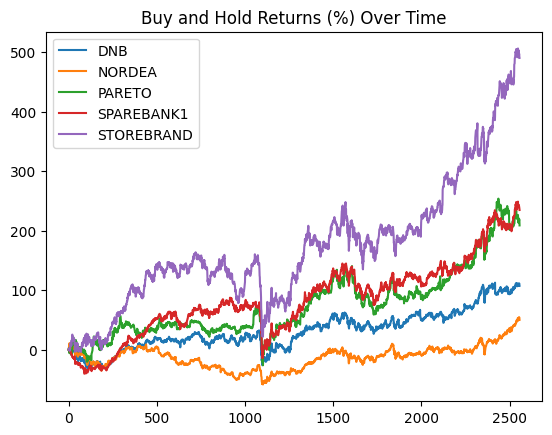

In [28]:
for ticker, prices in [
    ('DNB', DNB), 
    ('NORDEA', NORDEA), 
    ('PARETO', PARETO), 
    ('SPAREBANK1', SPAREBANK1), 
    ('STOREBRAND', STOREBRAND)]:
    plt.plot((prices/prices[0]-1)*100, label=ticker, linewidth=1.5)
plt.title('Buy and Hold Returns (%) Over Time')
plt.legend()
plt.show()

In [29]:
# Debug: Check date ranges before intersection
print("="*80)
print("DATE RANGE DEBUG")
print("="*80)
print(f"DNB_df:       {DNB_df.index.min().date()} to {DNB_df.index.max().date()} ({len(DNB_df)} days)")
print(f"NORDEA_df:    {NORDEA_df.index.min().date()} to {NORDEA_df.index.max().date()} ({len(NORDEA_df)} days)")
print(f"PARETO_df:    {PARETO_df.index.min().date()} to {PARETO_df.index.max().date()} ({len(PARETO_df)} days)")
print(f"SPAREBANK1_df:{SPAREBANK1_df.index.min().date()} to {SPAREBANK1_df.index.max().date()} ({len(SPAREBANK1_df)} days)")
print(f"STOREBRAND_df:{STOREBRAND_df.index.min().date()} to {STOREBRAND_df.index.max().date()} ({len(STOREBRAND_df)} days)")
print(f"OBX:          {OBX.index.min().date()} to {OBX.index.max().date()} ({len(OBX)} days)")
print(f"rf:           {rf.index.min().date()} to {rf.index.max().date()} ({len(rf)} days)")
print("="*80)


DATE RANGE DEBUG
DNB_df:       2009-02-09 to 2026-01-29 (4096 days)
NORDEA_df:    2015-01-05 to 2026-01-29 (2782 days)
PARETO_df:    2015-05-06 to 2026-01-29 (2585 days)
SPAREBANK1_df:2012-01-03 to 2026-01-29 (3530 days)
STOREBRAND_df:2000-01-03 to 2026-01-29 (6547 days)
OBX:          2000-01-03 to 2026-01-29 (6546 days)
rf:           2015-05-06 to 2026-01-29 (2558 days)



STRATEGY: ret_50_200

                            OLS Regression Results                            
Dep. Variable:           excess_strat   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     2336.
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:50:31   Log-Likelihood:                 38774.
No. Observations:               12785   AIC:                        -7.754e+04
Df Residuals:                   12783   BIC:                        -7.753e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.435e-05      0.

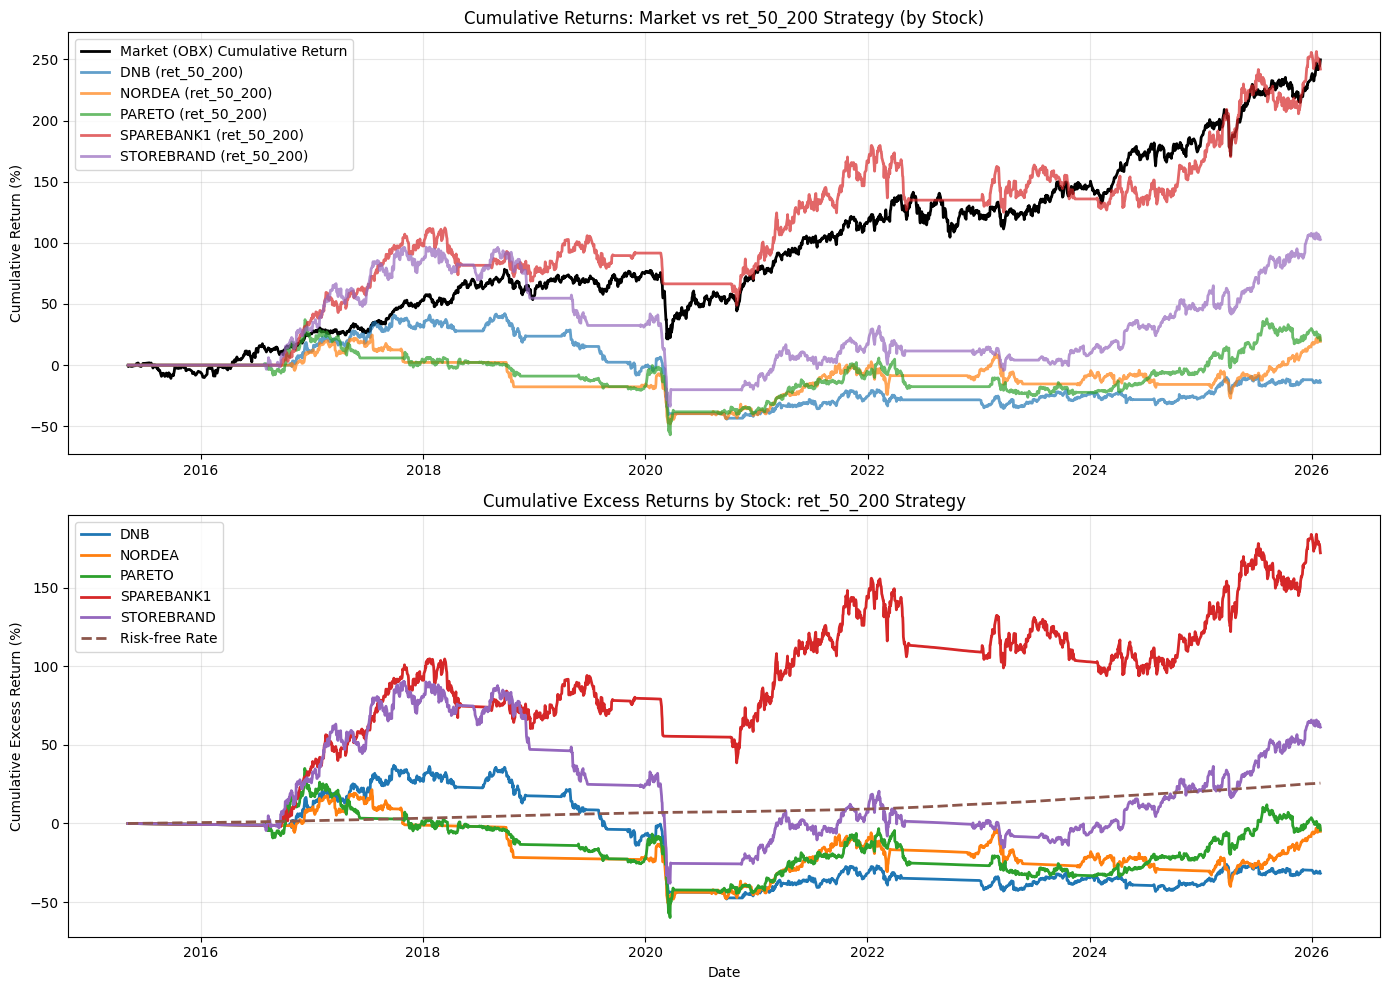


STRATEGY: ret_50_100

                            OLS Regression Results                            
Dep. Variable:           excess_strat   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     2402.
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:50:34   Log-Likelihood:                 38536.
No. Observations:               12785   AIC:                        -7.707e+04
Df Residuals:                   12783   BIC:                        -7.705e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.139e-05      0.

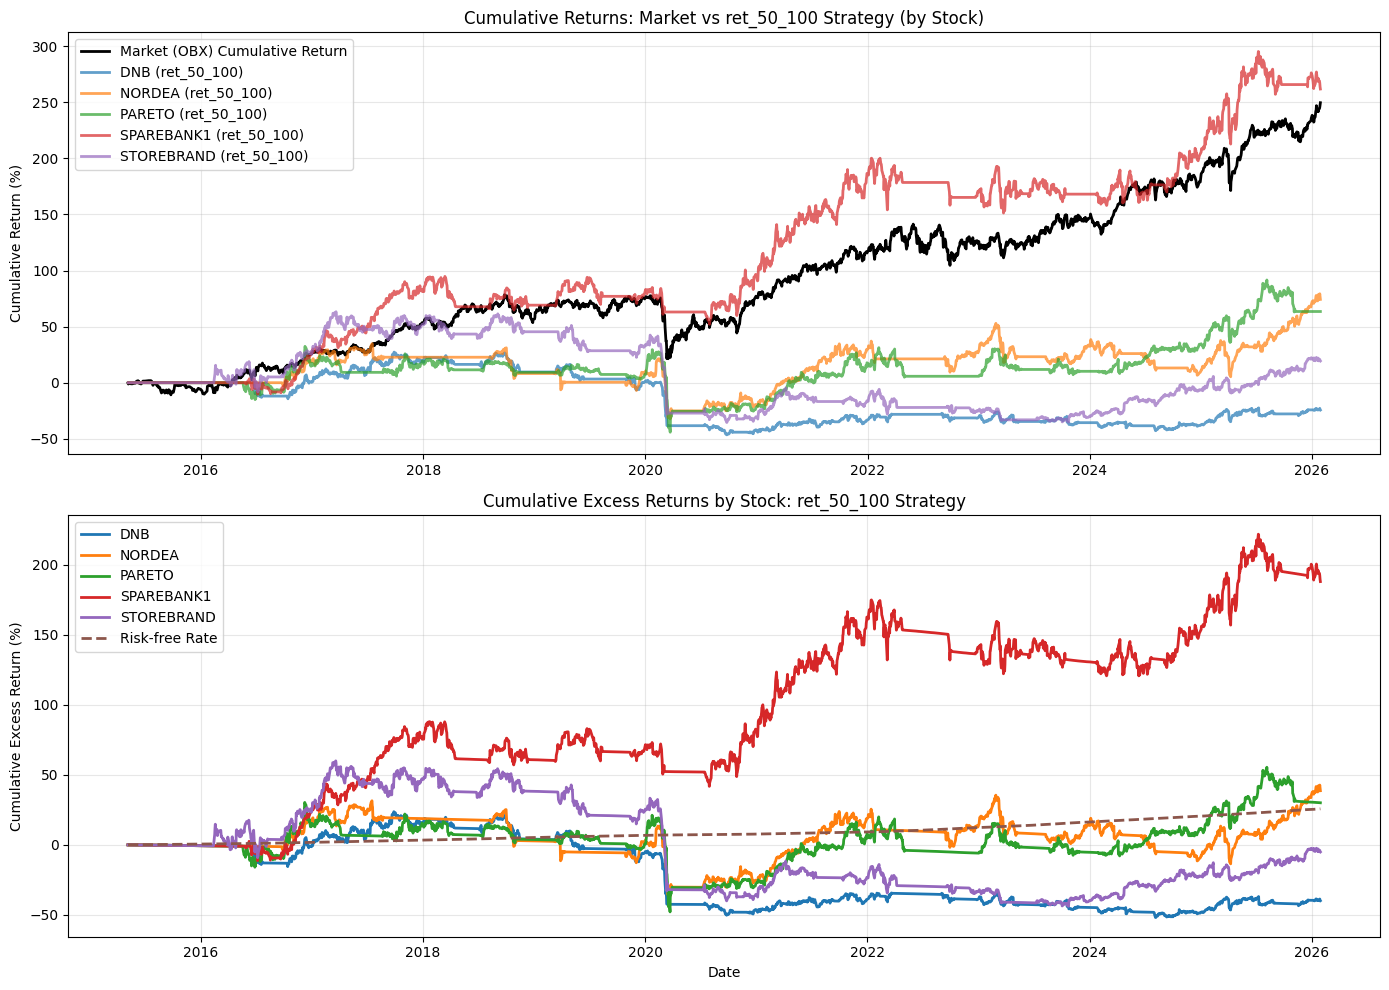


STRATEGY: ret_100_200

                            OLS Regression Results                            
Dep. Variable:           excess_strat   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     2689.
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:50:37   Log-Likelihood:                 38526.
No. Observations:               12785   AIC:                        -7.705e+04
Df Residuals:                   12783   BIC:                        -7.703e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.975e-05      0

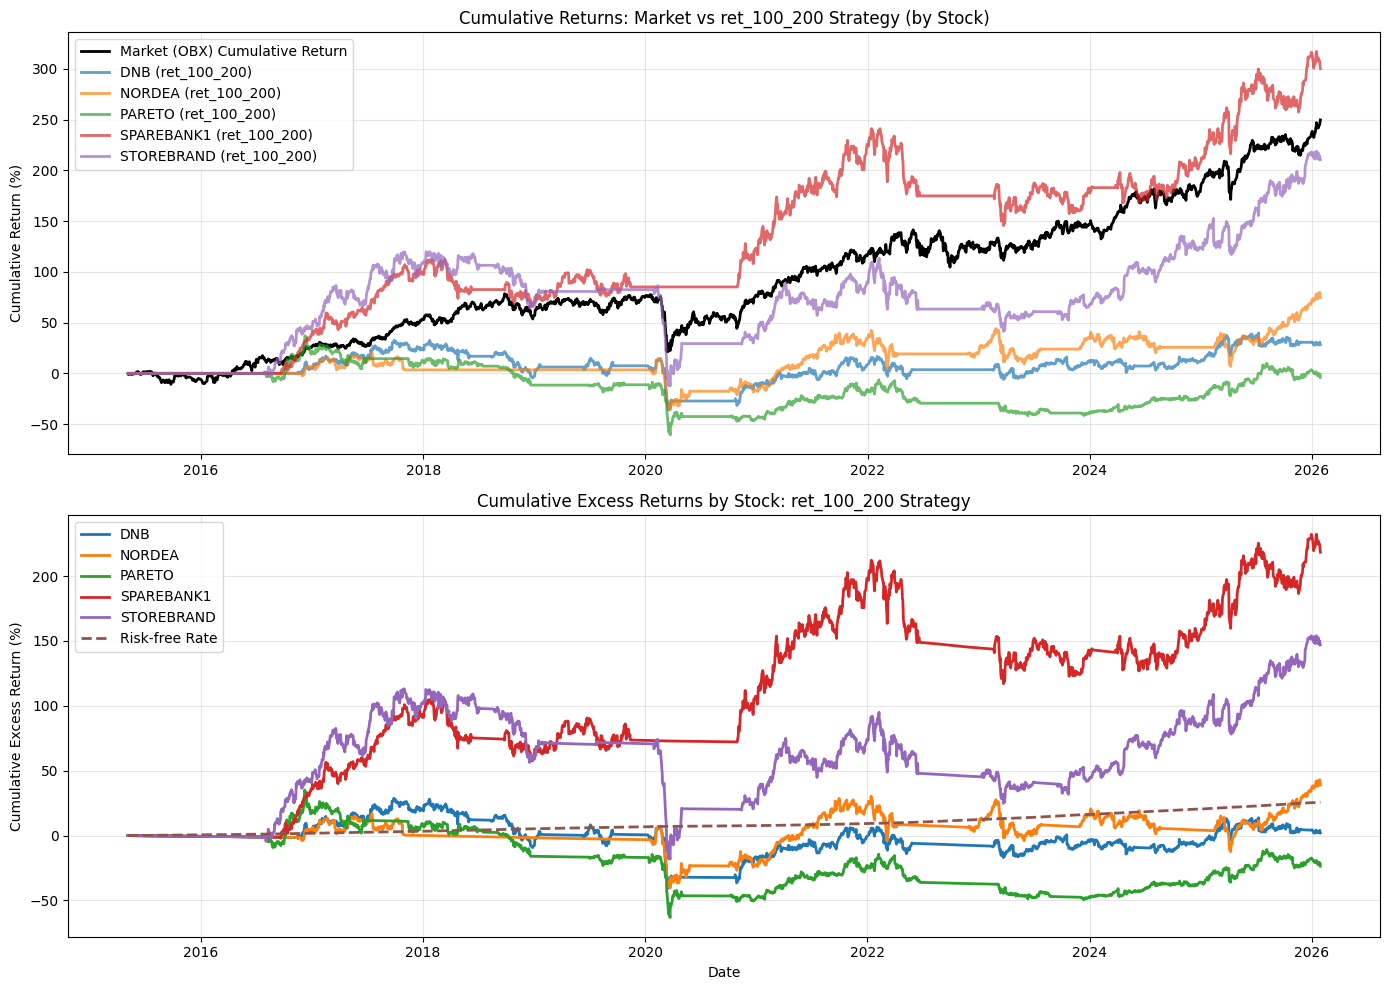

In [31]:
# Analyze and plot each strategy
strategies = ['ret_50_200', 'ret_50_100', 'ret_100_200']

for strategy_col in strategies:
    print(f"\n{'='*80}")
    print(f"STRATEGY: {strategy_col}")
    print(f"{'='*80}\n")
    
    # Run CAPM regression for this strategy
    model, pooled = pool_and_capm(returns_dict, market_ret, rf, strategy_col=strategy_col)
    print(model.summary())
    
    # Plot cumulative returns for this strategy
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Subplot 1: Cumulative returns - Market vs Strategy (by source, averaged)
    ax1 = axes[0]
    
    # Calculate cumulative market return (should be the same for all sources)
    market_ret_sorted = market_ret.sort_index()
    cumulative_mkt = (1 + market_ret_sorted).cumprod() - 1
    ax1.plot(market_ret_sorted.index, cumulative_mkt * 100, label='Market (OBX) Cumulative Return', linewidth=2, color='black')
    
    # Calculate cumulative strategy returns for each source separately and plot them
    for source in sorted(returns_dict.keys()):
        source_returns = returns_dict[source][strategy_col].sort_index()
        cumulative_strat = (1 + source_returns).cumprod() - 1
        ax1.plot(source_returns.index, cumulative_strat * 100, label=f'{source} ({strategy_col})', linewidth=2, alpha=0.7)
    
    ax1.set_ylabel('Cumulative Return (%)')
    ax1.set_title(f'Cumulative Returns: Market vs {strategy_col} Strategy (by Stock)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Cumulative EXCESS returns by source
    ax2 = axes[1]
    for source in sorted(pooled['source'].unique()):
        subset = pooled[pooled['source'] == source].sort_index()
        cumulative_ret = (1 + subset['excess_strat']).cumprod() - 1
        ax2.plot(subset.index, cumulative_ret * 100, label=source, linewidth=2)
    cumulative_rf = (1 + rf).cumprod() - 1
    ax2.plot(subset.index, cumulative_rf[:-1] * 100, label='Risk-free Rate', linewidth=2, linestyle='--')    

    ax2.set_ylabel('Cumulative Excess Return (%)')
    ax2.set_xlabel('Date')
    ax2.set_title(f'Cumulative Excess Returns by Stock: {strategy_col} Strategy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
